In [2]:
%load_ext autoreload
%autoreload 2

import os
import json
import pickle
import bisect
import scipy

from datetime import datetime
from tqdm import tqdm
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections

import sklearn
from scipy.cluster.vq import kmeans2
from sklearn.utils import shuffle


from dre_pdm import train_utils
from dre_pdm import utils
from dre_pdm import human

plt.figure(num=None, figsize=(28, 28), dpi=80, facecolor='w', edgecolor='k')

%matplotlib inline

In [3]:
RANDOM_SEED = 23
utils.set_all_random_seeds(RANDOM_SEED)

In [4]:
def stats_array(data):
    mean = np.mean(data)
    stddev = np.std(data, ddof=1)
    t_bounds = scipy.stats.t.interval(0.95, len(data) - 1)
    ci = [mean + critval * stddev / (len(data)**0.5) for critval in t_bounds]
    print("Mean: {:.4f} $\\pm$ {:.4f}".format(mean, ci[1] - mean))
    print("Confidence Interval 95%%: {}, {}".format(ci[0], ci[1]))
    print(scipy.stats.t.interval(0.95, len(data) - 1, loc=np.mean(data), scale=scipy.stats.sem(data)))
    print("Data: ", data)

In [5]:
from matplotlib import rc

# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':14})

# Set the font used for MathJax - more on this later
rc('mathtext',**{'default':'regular'})

# The following %config line changes the inline figures to have a higher DPI.
# You can comment out (#) this line if you don't have a high-DPI (~220) display.
%config InlineBackend.figure_format = 'retina'

In [6]:
T_INF = 10
T_EFF = 10
NUM_HUMANS = 10

## Load dataset

In [7]:
dataset = pickle.load(open("../data/dataset.pkl", "rb"))
equipment = pickle.load(open("../data/equipment.pkl", "rb"))

## Plot dataset

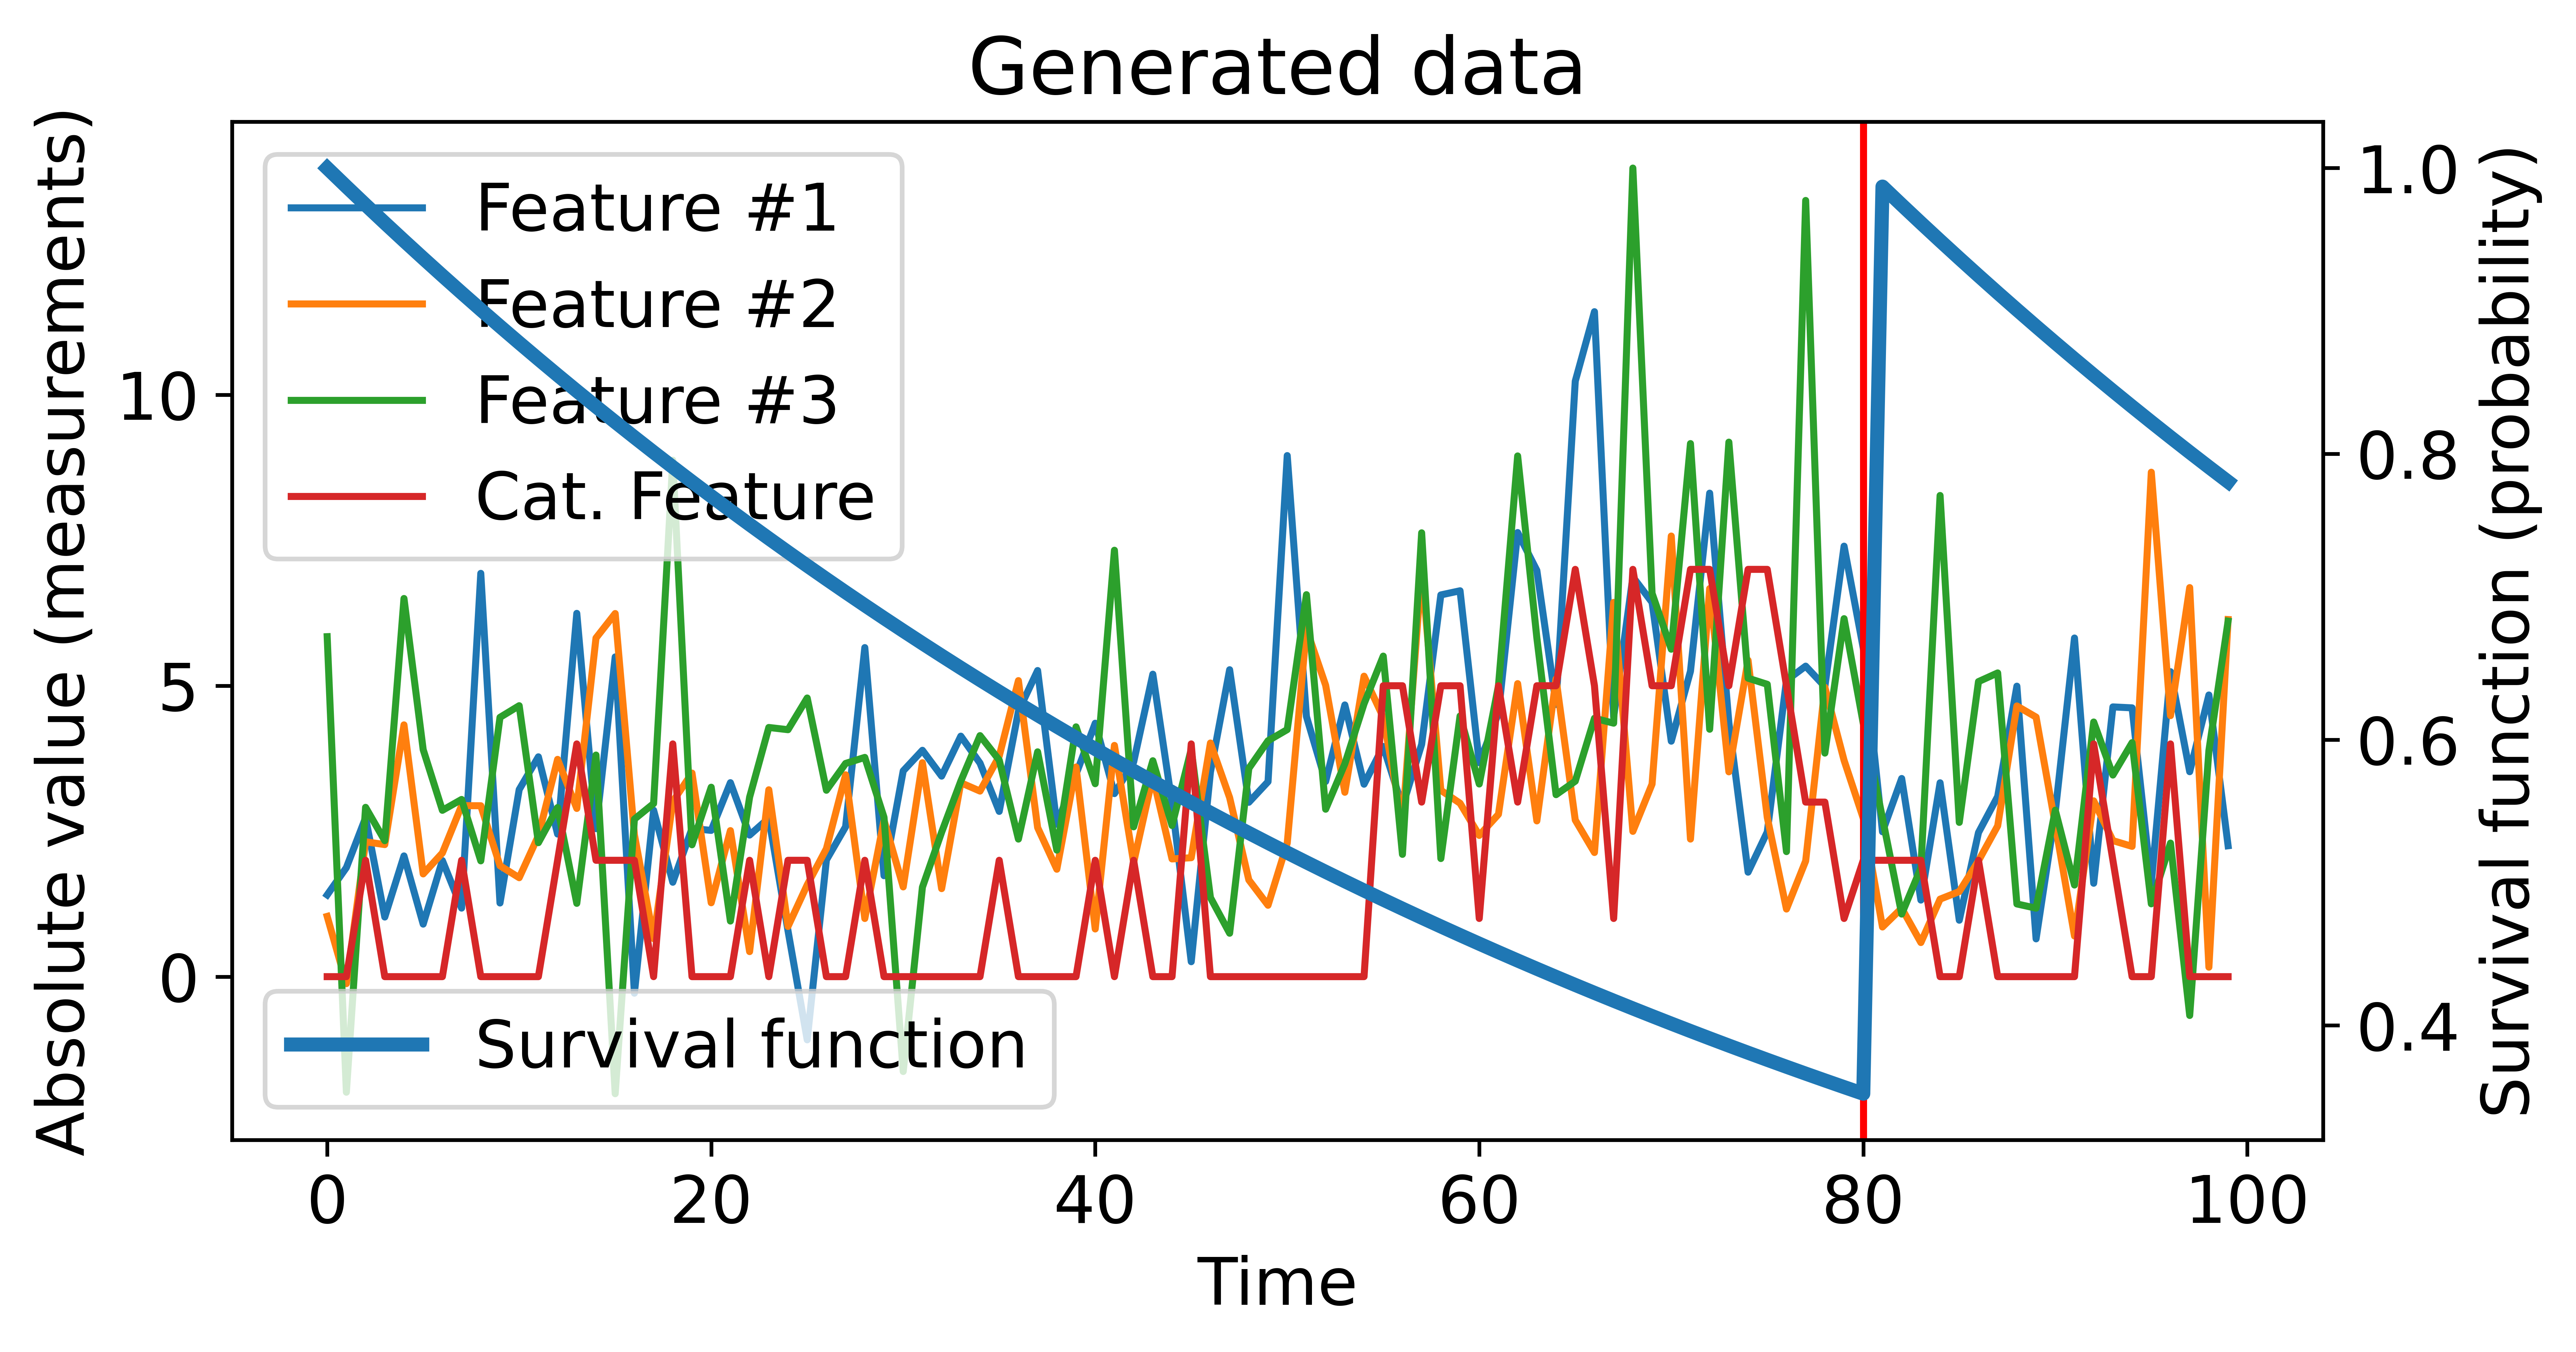

In [9]:
plt.figure(num=None, figsize=(8, 4), dpi=500, facecolor='w', edgecolor='k')

CAT_FEATURES = [0, 1, 2, 3, 4, 5, 6, 7]

encoders = {d: sklearn.preprocessing.OneHotEncoder() for d in CAT_FEATURES}
for d in CAT_FEATURES:
    encoders[d].fit([[d],[d+2], [d+4], [d+1], [d+3], [d+5], [d+7]])

T = dataset.shape[-1]
timestamps = np.arange(0, T, 1)
ID = 97
sns.lineplot(x=timestamps, y=dataset[ID, -3], label="Feature #1")
sns.lineplot(x=timestamps, y=dataset[ID, -2], label="Feature #2")
sns.lineplot(x=timestamps, y=dataset[ID, -1], label="Feature #3")
sns.lineplot(x=timestamps, y=[encoders[0].inverse_transform([d])[0, 0] for d in dataset[ID, 0:7].T], label="Cat. Feature")
for t in equipment[ID]["fixes"]:
    plt.axvline(t, 0, 6000, c="r", label="Fix occured")

plt.xlabel("Time")
plt.ylabel("Absolute value (measurements)")

ax2 = plt.twinx()
sns.lineplot(x=np.arange(0, T, 1), y=equipment[ID]["ss"], ax=ax2, label="Survival function", linewidth=3)
plt.ylabel("Survival function (probability)")
plt.title("Generated data")

#plt.savefig('generated_data.pdf', bbox_inches='tight')
plt.savefig('generated_data.png', bbox_inches='tight', dpi=300) 

## Prepare ML problem

In [10]:
def check_malfunction(equipment, t_min, t_max):
    fixes = equipment["fixes"]
    left_id = bisect.bisect_left(fixes, t_min)
    if left_id < len(fixes) and fixes[left_id] >= t_min and fixes[left_id] < t_max:
        return 1
    else:
        return 0
    

def _last(ds, axis):
    return ds[:, :, -1]
    
    
def aggregate(ds):
    new_ds = []
    for agg_ in [np.min, np.mean, np.max, _last]:
        new_ds.append(agg_(ds, axis=2))
    return np.transpose(np.array(new_ds), (1, 2, 0))
    


def generate_dataset(cur_ds, equipment, t_inf, t_eff):
    Xs, ys = [], []
    for t in range(0, cur_ds.shape[-1] - t_inf - t_eff, t_eff):
        Xs.append(cur_ds[:, t:t + t_inf])
        ys.append(check_malfunction(equipment, t_min=t+t_inf, t_max=t+t_inf+t_eff))
    return Xs, ys


X, y = [], []
for i in range(dataset.shape[0]):
    cur_X, cur_y = generate_dataset(dataset[i], equipment[i], t_inf=T_INF, t_eff=T_EFF)
    X.extend(cur_X)
    y.extend(cur_y)
    
X, y = np.array(X), np.array(y)

In [11]:
X_aggregated = aggregate(X)
X_aggregated = X_aggregated.reshape(*X_aggregated.shape[:-2], -1)
assert X_aggregated.shape[0] == y.shape[0]

## Evaluation

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import xgboost

from dre_pdm.human import Human
from dre_pdm import utils


X_train, X_test, y_train, y_test = train_test_split(X_aggregated, y, test_size=0.66, random_state=RANDOM_SEED)

scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)

X_test  = scaler.transform(X_test)
X_scaled = scaler.transform(X_aggregated)

## Evaluate Logistic regression

In [ ]:
collections.Counter(y)

In [ ]:
f1_scores, precisions, recalls, model, ds = \
    train_utils.validate_model_classification_stats(sklearn.linear_model.LogisticRegression, X_aggregated, y, test_size=0.33, limit=20)

In [ ]:
print("F1 score: {} ± {}".format(round(np.mean(f1_scores), 4), 
                                 round(np.std(f1_scores), 4)))

print("Precision: {} ± {}".format(round(np.mean(precisions), 4), 
                                  round(np.std(precisions), 4)))

print("Recall: {} ± {}".format(round(np.mean(recalls), 4), 
                               round(np.std(recalls), 4)))

stats_array(f1_scores)

## Evaluate Gradient Boosting

In [ ]:
f1_scores, precisions, recalls, xgb_model, datasets = \
    train_utils.validate_model_classification_stats(xgboost.XGBClassifier, X_aggregated, y, limit=20, test_size=0.33)

print("NUM_HUMANS={}".format(NUM_HUMANS))
print("F1 score: {} ± {}".format(round(np.mean(f1_scores), 4), 
                                 round(np.std(f1_scores), 4)))

print("Precision: {} ± {}".format(round(np.mean(precisions), 4), 
                                  round(np.std(precisions), 4)))

print("Recall: {} ± {}".format(round(np.mean(recalls), 4),
                               round(np.std(recalls), 4)))

In [ ]:
stats_array(f1_scores)

## Evaluate Extra-Trees Classifier

In [ ]:
f1_scores, precisions, recalls, model, ds = \
    train_utils.validate_model_classification_stats(sklearn.ensemble.ExtraTreesClassifier, X_aggregated, y, limit=20, test_size=0.33)
print("F1 score: {} ± {}".format(round(np.mean(f1_scores), 4),
                                 round(np.std(f1_scores), 4)))

print("Precision: {} ± {}".format(round(np.mean(precisions), 4), 
                                  round(np.std(precisions), 4)))

print("Recall: {} ± {}".format(round(np.mean(recalls), 4), 
                               round(np.std(recalls), 4)))

stats_array(f1_scores)

In [ ]:
model.n_estimators

## Evaluate DRE:

In [15]:
RATIO_TO_LOOK = 0.07
NUM_HUMANS = 25
MAX_DEPTH = 6
TEST_SIZE = 0.33
alphas = np.arange(0.1, 1.0, 0.05)
all_additional_datasets = {}


def initialize_humans():
    humans = []

    for i in range(NUM_HUMANS):
        experience = np.random.normal(0.75, 0.05)
        depth = int(MAX_DEPTH * np.random.rand()) + 2
        human = Human(experience=experience, depth=depth)
        humans.append(human)
    return humans

all_additional_datasets[NUM_HUMANS] = []

In [ ]:
all_evaluations = []
for alpha in alphas:
    humans = initialize_humans()
    f1_scores, precisions, recalls, xgb_model, datasets = train_utils.validate_model_classification_stats(
        train_utils.DRE_classifier, X_aggregated, y, humans, alpha_dre=alpha,
        test_size=0.33, limit=20, ratio_to_look=RATIO_TO_LOOK)

    all_additional_datasets[NUM_HUMANS].append(datasets)
    all_evaluations.append((f1_scores, precisions, recalls, xgb_model))
    print("Alpha={}, f1={}±{}".format(alpha, np.mean(f1_scores), np.std(f1_scores)))
    stats_array(f1_scores)

## Visualize Performance and Alphas

Humans 1: experiments/results/list_1.txt

Humans 5: experiments/results/list_5.txt

Humans 15: experiments/results/list_25.txt

In [12]:
performances = {
    1: {
        "f1": np.array([0.3552, 0.4150, 0.4182, 0.4217, 0.4274, 0.4339,
                        0.4373, 0.4403, 0.4439, 0.4192, 0.4003, 0.3927,
                        0.3801, 0.3706, 0.3647, 0.3629, 0.3546, 0.3483]),
        "std": np.array([0.0381, 0.0199, 0.0203, 0.0195, 0.0164, 0.0169, 
                         0.0163, 0.0171, 0.0188, 0.0193, 0.0179, 0.0210,
                         0.0221, 0.0219, 0.0218, 0.0238, 0.0232, 0.0247])
    },
    5: {
        "f1": np.array([0.4662, 0.4679, 0.4723, 0.4731, 0.4788, 0.4763, 
                        0.4775, 0.4775, 0.4536, 0.4263, 0.4051, 0.3913,
                        0.3809, 0.3746, 0.3688, 0.3653, 0.3559, 0.3484]),
        "std": np.array([0.0162, 0.0171, 0.0170, 0.0171, 0.0168, 0.0167,
                         0.0159, 0.0162, 0.0169, 0.0174, 0.0180, 0.0188,
                         0.0221, 0.0216, 0.0235, 0.0243, 0.0233, 0.0244])
    },
    25: {
        "f1": np.array([0.5360, 0.5482, 0.5505, 0.5509, 0.5566, 0.5622,
                        0.5654, 0.5670, 0.5165, 0.4627, 0.4303, 0.4131,
                        0.3982, 0.3861, 0.3761, 0.3711, 0.3602, 0.3500]),
        "std": np.array([0.0223, 0.0199, 0.0186, 0.0176, 0.0177, 0.0180,
                         0.0202, 0.0210, 0.0201, 0.0185, 0.0187, 0.0209,
                         0.0228, 0.0225, 0.0238, 0.0239, 0.0224, 0.0241])
    }
}

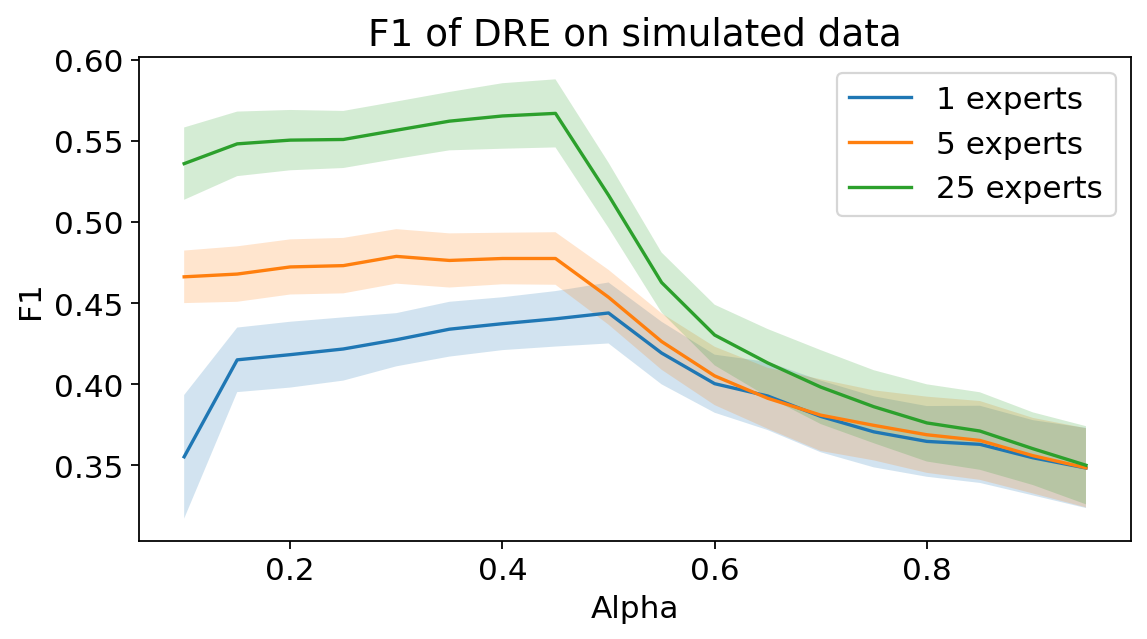

In [16]:
plt.figure(num=None, figsize=(8, 4), dpi=80, facecolor='w', edgecolor='k')

for ID in performances.keys():
    ax = sns.lineplot(x=alphas, y=performances[ID]["f1"], label="{} experts".format(ID))
    ax.fill_between(x=alphas, y1=performances[ID]["f1"] - performances[ID]["std"], y2=performances[ID]["f1"] + performances[ID]["std"], alpha=.2)
plt.xlabel("Alpha")
plt.ylabel("F1")
plt.title("F1 of DRE on simulated data")
plt.savefig('f1_dre_simulated.pdf', bbox_inches='tight')